In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lmfit as lf
import os
import seaborn as sns

sns.set_context('paper') # makes text larger (poster) or smaller (paper)

from lmfit.models import DampedOscillatorModel

In [2]:
"""Import files from Folder"""


#base = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/ResonanceCurves/'
base = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\ResonanceCurves'


path = os.path.join(base, 'Array01.00r0.5p3Device1.2Drum1Couping500/Data.csv')

"#fig.savefig('/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports/NormalModeSplitCurve.png')\nfig.savefig('/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports/NormalModeSplitCurve.svg', format='svg', dpi=1200,  bbox_inches= 'tight', pad_inches=0.05)\nfig.savefig('/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports/NormalModeSplitCurve.pdf', bbox_inches= 'tight', pad_inches=0.05)\n"

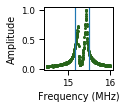

In [3]:
"""Define column names and plot response curve"""


colnames = ['SweepVal', 'F', 'R', 'theta', 'NEP_BW', 'R_ref', 'theta_ref', 'Amp', 'Phase']

df = pd.read_csv(path, names = colnames)

maxR = df['R'].max()
df['Rnorm'] = (df.R) / (maxR)
df['Fnorm'] = df.F / 10**6

fig, ax = plt.subplots(figsize=(1.25,1.15))
sty = {'markersize':4}
ax.plot(df.Fnorm, (df.Rnorm), '.', color=('#276419'),**sty)
ax.axvline(15.16)
ax.axvline(15.5)

ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Amplitude')
#ax.set_title('Response Curve')

"""#fig.savefig('/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports/NormalModeSplitCurve.png')
fig.savefig('/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports/NormalModeSplitCurve.svg', format='svg', dpi=1200,  bbox_inches= 'tight', pad_inches=0.05)
fig.savefig('/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports/NormalModeSplitCurve.pdf', bbox_inches= 'tight', pad_inches=0.05)
"""
#fig.set_size_inches(18.5, 10.5, forward=True)

## Take mode maps slightly off resonance to avoid significant amplitude change due to heating.

Text(0.5, 1.0, 'Response Curve')

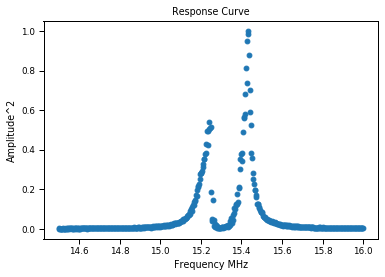

In [4]:
"""Normalize F and R^2 values"""

maxR = df['R'].max()

df['Rnorm'] = (df.R) / (maxR)
df['Fnorm'] = df.F / 10**6
df['Rnorm2']= ((df.R)/maxR)**2

fig, ax = plt.subplots()
ax.plot(df.Fnorm, df.Rnorm2, 'o')

ax.set_xlabel('Frequency MHz')
ax.set_ylabel('Amplitude^2')
ax.set_title('Response Curve')

In [5]:
"""Find resonant frequency of first peak"""
s = df['Fnorm'] < 15.2
a = df['Fnorm'] > 15.4

maxR1 = df[s]['R'].max()
maxR2 = df[a]['R'].max()

maxFreqIn1 = (df[s]['R'].idxmax())
maxFreqIn2 = (df[a]['R'].idxmax())

res1 = df['Fnorm'].values[maxFreqIn1]
res2 = df['Fnorm'].values[maxFreqIn2]

print (maxFreqIn2)

311


In [6]:
"""Define Model"""


peak1 = DampedOscillatorModel(prefix = 'p1_')
peak2 = DampedOscillatorModel(prefix = 'p2_') 

print (peak1.param_names)
print (peak2.param_names)

['p1_amplitude', 'p1_center', 'p1_sigma']
['p2_amplitude', 'p2_center', 'p2_sigma']


[[Model]]
    (Model(damped_oscillator, prefix='p1_') + Model(damped_oscillator, prefix='p2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 190
    # data points      = 500
    # variables        = 6
    chi-square         = 1.57843965
    reduced chi-square = 0.00319522
    Akaike info crit   = -2867.08565
    Bayesian info crit = -2841.79800
[[Variables]]
    p1_amplitude:  0.00174430 +/- 7.7458e-05 (4.44%) (init = 6.580075e-05)
    p1_center:     15.2152724 +/- 0.00125988 (0.01%) (init = 15.19739)
    p1_sigma:      0.00147416 +/- 9.4415e-05 (6.40%) (init = 0.0005)
    p1_height:     0.59162725 +/- 0.02034773 (3.44%) == '0.5000000*p1_amplitude/max(2.220446049250313e-16, p1_sigma)'
    p1_fwhm:       0.07769924 +/- 0.00497676 (6.41%) == 'sqrt(abs(p1_center**2*(1-2*p1_sigma**2)+(2*sqrt(p1_center**4*p1_sigma**2*(p1_sigma**2+3)))))-sqrt(abs(p1_center**2*(1-2*p1_sigma**2)-(2*sqrt(p1_center**4*p1_sigma**2*(p1_sigma**2+3)))))'
    p2_amplitude:  0.00199354 

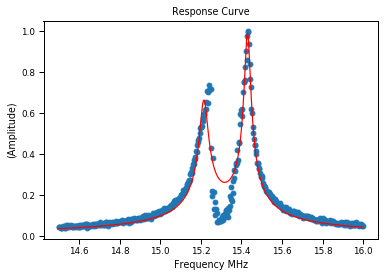

In [7]:
"""Fit data with Damped Oscillator Model"""


guessQ = 1000

params1 = peak1.make_params(p1_sigma = 1/(2*guessQ), p1_center = res1, p1_amplitude = 1 / (guessQ*res1))
params2 = peak2.make_params(p2_sigma = 1/(2*guessQ), p2_center = res1, p2_amplitude = 1 / (guessQ*res1))

params = params1 +params2

model = peak1 + peak2

result = model.fit(df.Rnorm, params, x = df.Fnorm)

fig, ax = plt.subplots()
ax.plot(df.Fnorm, df.Rnorm, 'o', df.Fnorm, result.best_fit, 'r-')

ax.set_xlabel('Frequency MHz')
ax.set_ylabel('(Amplitude)')
ax.set_title('Response Curve')

print(result.fit_report())

In [8]:
"""Caluculate Quality Factor"""


Q1 = 1/(2*result.params['p1_sigma'].value)
Q2 = 1/(2*result.params['p2_sigma'].value)

print(Q1, Q2)

339.1767785179802 465.5366322907487


In [9]:
"""Caluculate Quality Factor"""


Q1 = result.params['p1_center'].value/(result.params['p1_fwhm'].value)
Q2 = result.params['p2_center'].value/(result.params['p2_fwhm'].value)

print(Q1, Q2)

195.82266956336903 268.77687317871977


In [10]:
"""Caluculate linewidth in kHz"""


Q1 = (result.params['p1_fwhm'].value)*10**3
Q2 = (result.params['p2_fwhm'].value)*10**3

print(Q1, Q2)

77.69923875850537 57.409578273491135


Text(0.5, 1.0, 'Response Curve')

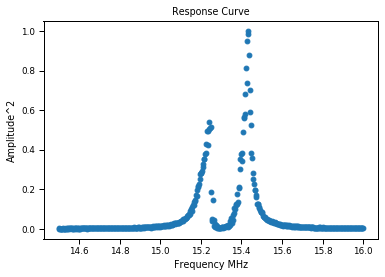

In [11]:
"""Normalize F and R^2 values"""

maxR = df['R'].max()

df['Rnorm'] = (df.R) / (maxR)
df['Fnorm'] = df.F / 10**6
df['Rnorm2']= ((df.R)/maxR)**2

fig, ax = plt.subplots()
ax.plot(df.Fnorm, df.Rnorm2, 'o')

ax.set_xlabel('Frequency MHz')
ax.set_ylabel('Amplitude^2')
ax.set_title('Response Curve')

In [12]:
"""Find resonant frequency of first peak"""
s = df['Fnorm'] < 15.2
a = df['Fnorm'] > 15.4

maxR1 = df[s]['R'].max()**2
maxR2 = df[a]['R'].max()**2

maxFreqIn1 = (df[s]['R'].idxmax())
maxFreqIn2 = (df[a]['R'].idxmax())

res1 = df['Fnorm'].values[maxFreqIn1]
res2 = df['Fnorm'].values[maxFreqIn2]

print (maxFreqIn2)

311


In [13]:
peak1 = DampedOscillatorModel(prefix = 'p1_')
peak2 = DampedOscillatorModel(prefix = 'p2_') 

print (peak1.param_names)
print (peak2.param_names)

['p1_amplitude', 'p1_center', 'p1_sigma']
['p2_amplitude', 'p2_center', 'p2_sigma']


[[Model]]
    (Model(damped_oscillator, prefix='p1_') + Model(damped_oscillator, prefix='p2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3346
    # data points      = 500
    # variables        = 6
    chi-square         = 3.03572235
    reduced chi-square = 0.00614519
    Akaike info crit   = -2540.07935
    Bayesian info crit = -2514.79170
[[Variables]]
    p1_amplitude:  3.72124826 +/- 15524.8893 (417195.74%) (init = 6.580075e-05)
    p1_center:     15.4377170 +/- 0.01496540 (0.10%) (init = 15.19739)
    p1_sigma:      0.00122386 +/- 7.0330e-04 (57.47%) (init = 0.0005)
    p1_height:     1520.29165 +/- 6341740.72 (417139.75%) == '0.5000000*p1_amplitude/max(2.220446049250313e-16, p1_sigma)'
    p1_fwhm:       0.06544963 +/- 0.03767352 (57.56%) == 'sqrt(abs(p1_center**2*(1-2*p1_sigma**2)+(2*sqrt(p1_center**4*p1_sigma**2*(p1_sigma**2+3)))))-sqrt(abs(p1_center**2*(1-2*p1_sigma**2)-(2*sqrt(p1_center**4*p1_sigma**2*(p1_sigma**2+3)))))'
    p2_amplitude:

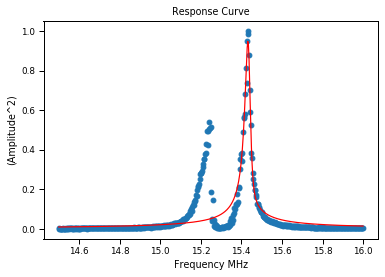

In [14]:
"""Fit data with Damped Oscillator Model"""


guessQ = 1000

params1 = peak1.make_params(p1_sigma = 1/(2*guessQ), p1_center = res1, p1_amplitude = 1 / (guessQ*res1))
params2 = peak2.make_params(p2_sigma = 1/(2*guessQ), p2_center = res1, p2_amplitude = 1 / (guessQ*res1))

params = params1 +params2

model = peak1 + peak2

result = model.fit(df.Rnorm2, params, x = df.Fnorm)

fig, ax = plt.subplots()
ax.plot(df.Fnorm, df.Rnorm2, 'o', df.Fnorm, result.best_fit, 'r-')

ax.set_xlabel('Frequency MHz')
ax.set_ylabel('(Amplitude^2)')
ax.set_title('Response Curve')

print(result.fit_report())

In [15]:
"""Caluculate linewidth in kHz"""


Q1 = (result.params['p1_fwhm'].value)*10**3
Q2 = (result.params['p2_fwhm'].value)*10**3

print(Q1, Q2)

65.44962638321827 65.4672541945569
